In [3]:
import pymc as pm
import arviz as az
import jax.numpy as jnp
import numpy as np
import aesara.tensor as at
from to_delete.timing import timing_van_jax, comp_gen_D, mono_next_grlex, numCoeffsPoly
from modules.polyfit import Polyfit
import json

#IMPORT DUMMY DATA
dummy_fits = Polyfit('dummy_data/fits.npz', input_h5='dummy_data/inputdata.h5', order=3, covariance=True)
coeff = np.array(dummy_fits.p_coeffs)
cov = np.array(dummy_fits.cov)
sd_coeff = np.sqrt(np.diagonal(np.array(cov), axis1=1, axis2=2))
sd_coeff[np.where(sd_coeff==0)]=0.01
deg=3

#Import target data
with open("dummy_data/target_data.json", 'r') as f:
    target_data = json.loads(f.read())
target_values = np.array([target_data[k][0] for k in target_data])
target_error = np.array([target_data[k][1] for k in target_data])
target_error[np.where(target_error==0)]=0.01


#GUESS+COMP
param_guess = np.array([1.44, -1.1])
comp = np.array(comp_gen_D(param_guess.size, deg))
term_list = [[0]*2]
for i in range(1, numCoeffsPoly(2, 3)):
    term_list.append(mono_next_grlex(2, term_list[-1][:]))
grlex_pow = np.array(term_list)

#DUMMY DATA ALTERNATE
p = np.array([1.5, -1])
ppoly = np.prod(np.power(p, grlex_pow[:, np.newaxis]), axis=2)
y_test = np.dot(coeff, ppoly).flatten()
print(y_test)


#MODEL
with pm.Model() as model:
    p = pm.Normal('params', param_guess, sigma=np.abs(param_guess/5), shape=np.shape(param_guess))
    #p_poly = pm.Deterministic('p_poly', tt.prod(tt.power(p, comp[:, np.newaxis]), axis=2, no_zeros_in_input=True))
    
    true_coeff = pm.Normal('true_coeff', mu=coeff, sigma=sd_coeff, shape=np.shape(coeff))
    #likelihood_coeff = pm.Normal('x', mu=true_coeff, sigma=sd_coeff, observed=coeff)

    true_y = at.dot(true_coeff, at.prod(at.power(p, grlex_pow[:, np.newaxis]), axis=2, no_zeros_in_input=True)).flatten()
    likelihood_y = pm.Normal('y', mu=true_y, sigma=target_error, observed=y_test)

    step = pm.NUTS()
    trace = pm.sample(100, step, tune=1000)

    



Fitting bins: 
/func0#0, /func0#1, /func0#2, /func0#3, /func0#4, /func0#5, /func0#6, /func0#7, /func0#8, /func0#9, /func0#10, /func0#11, /func0#12, /func0#13, /func0#14, /func0#15, /func0#16, /func0#17, /func0#18, /func0#19, /func1#0, /func1#1, /func1#2, /func1#3, /func1#4, /func1#5, /func1#6, /func1#7, /func1#8, /func1#9, /func1#10, /func1#11, /func1#12, /func1#13, /func1#14, /func1#15, /func1#16, /func1#17, /func1#18, /func1#19,  inner loop done!
[ 3.20484204e+00  3.49075379e+00  3.83429909e+00  4.92975918e+00
  4.72237780e+00  4.87227866e+00  4.68426416e+00  4.18689805e+00
  3.74717465e+00  2.97625028e+00  2.54079594e+00  1.83704491e+00
  1.42270873e+00  9.81610879e-01  6.18008516e-01  4.07402088e-01
  2.49878490e-01  1.49663656e-01  8.63797165e-02  3.71811386e-02
  3.84534929e+00  4.60706604e+00  5.19367383e+00  6.45737935e+00
  7.71207287e+00  6.63330159e+00  6.09959658e+00  4.51435346e+00
  2.99412160e+00  1.53426231e+00  7.71251721e-01  2.94576428e-01
  7.55311865e-02  2.0135694

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [params, true_coeff]
INFO:pymc:NUTS: [params, true_coeff]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 173 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 173 seconds.


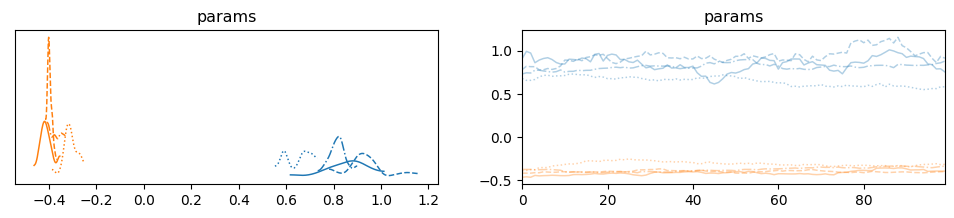

In [4]:
with model:
    az.plot_trace(trace, var_names='params')
    #az.plot_trace(trace, var_names='true_coeff')

In [33]:

"""chain_count = trace.get_values('params').shape[0]
y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model)
data_spp = az.from_pymc3(trace=trace, posterior_predictive=y_pred_g)

posterior_params = az.plot_posterior(data_spp, var_names='params', hdi_prob=.95, point_estimate='mean', textsize=20, round_to=4)"""
az.summary(trace)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
params[0],1.292,0.130,1.057,1.555,0.012,0.009,116.0,183.0,1.03
params[1],-0.809,0.044,-0.892,-0.734,0.004,0.003,133.0,197.0,1.03
"true_coeff[0, 0]",80.535,3.024,75.172,86.256,0.170,0.120,316.0,270.0,1.01
"true_coeff[0, 1]",105.149,5.882,94.914,117.070,0.385,0.273,238.0,288.0,1.00
"true_coeff[0, 2]",-78.954,1.892,-82.248,-75.513,0.098,0.070,362.0,335.0,1.01
...,...,...,...,...,...,...,...,...,...
"true_coeff[39, 5]",-0.000,0.001,-0.001,0.001,0.000,0.000,340.0,327.0,1.01
"true_coeff[39, 6]",0.000,0.001,-0.001,0.001,0.000,0.000,282.0,286.0,1.01
"true_coeff[39, 7]",0.000,0.001,-0.001,0.001,0.000,0.000,318.0,303.0,1.01
"true_coeff[39, 8]",-0.000,0.001,-0.001,0.001,0.000,0.000,369.0,307.0,1.02


In [34]:
#print(coeff)
print(y_test)

p = np.array([1.292, -0.809])

ppoly = np.prod(np.power(p, grlex_pow[:, np.newaxis]), axis=2)

y_fit = np.dot(coeff, ppoly).flatten()
print(y_fit - y_test)

[ 3.20484204e+00  3.49075379e+00  3.83429909e+00  4.92975918e+00
  4.72237780e+00  4.87227866e+00  4.68426416e+00  4.18689805e+00
  3.74717465e+00  2.97625028e+00  2.54079594e+00  1.83704491e+00
  1.42270873e+00  9.81610879e-01  6.18008516e-01  4.07402088e-01
  2.49878490e-01  1.49663656e-01  8.63797165e-02  3.71811386e-02
  3.84534929e+00  4.60706604e+00  5.19367383e+00  6.45737935e+00
  7.71207287e+00  6.63330159e+00  6.09959658e+00  4.51435346e+00
  2.99412160e+00  1.53426231e+00  7.71251721e-01  2.94576428e-01
  7.55311865e-02  2.01356942e-02  3.39692619e-03  4.80053417e-04
 -3.75325767e-05  1.31977631e-05  0.00000000e+00  0.00000000e+00]
[7.04660037e-01 1.17220163e+00 2.15106577e+00 1.16529019e+00
 7.56463953e-01 1.40542591e-01 7.65262812e-01 1.89050302e+00
 1.34586956e+00 2.06396372e+00 4.18502513e-01 1.53081501e+00
 1.02176742e+00 5.03847758e-01 5.31535942e-01 3.45129806e-01
 3.60141048e-01 2.55874000e-01 1.41970947e-01 1.24171618e-01
 4.40425985e-01 1.46860234e+00 1.39871544e+0

In [14]:
print(target_values)

[3.0905e+00 3.7335e+00 4.2920e+00 4.7360e+00 4.9600e+00 4.8570e+00
 4.6835e+00 4.3480e+00 3.7735e+00 3.1195e+00 2.5680e+00 1.9140e+00
 1.3580e+00 9.6750e-01 6.5600e-01 4.0700e-01 2.5850e-01 1.4950e-01
 8.5500e-02 4.2500e-02 3.8030e+00 4.6720e+00 5.6315e+00 6.5390e+00
 6.7950e+00 6.6395e+00 5.7945e+00 4.4550e+00 2.9320e+00 1.6250e+00
 7.3300e-01 2.7350e-01 8.4000e-02 1.7500e-02 4.0000e-03 1.0000e-03
 5.0000e-04 0.0000e+00 0.0000e+00 0.0000e+00]


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, true_x]
INFO:pymc:NUTS: [p, true_x]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 4 seconds.
INFO:pymc:Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 4 seconds.


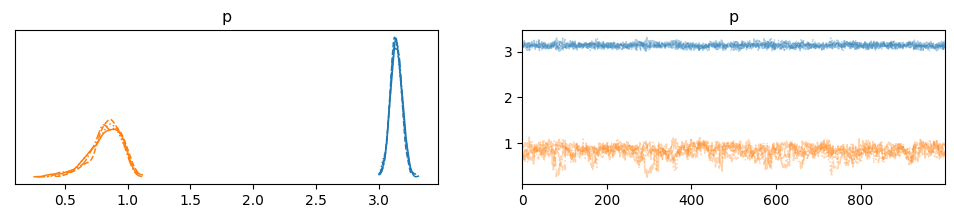

In [53]:
import jax.random as random
import numpy as np
import pymc as pm
import arviz as az

m = 3
c = 1


def f_real(x):
    return m*np.sqrt(x) + m**2*np.sqrt(x) + c

#create x-points of "fake" data
x_max = 1
pt_num = 10
x_dat = np.linspace(0, x_max, pt_num)
x_unc = 0.5*(np.square(x_dat)+x_max/10)/pt_num

#create random abberation in y
key = random.PRNGKey(27)
abrt_scale = 0.1*x_max*m
def f_abrt(x):
    return m*np.sqrt(x) + m**2*np.sqrt(x) + c + abrt_scale*random.normal(key, shape=(x.size,))


f_dat = np.array(f_abrt(x_dat))
comp = np.array([[1,0], [2,0], [0,1]])

with pm.Model() as lin_model:
    p = pm.Normal('p', 0.5, sigma=0.5, shape=(2,)) 
    p_poly = at.prod(at.pow(p, comp[:, np.newaxis]), axis=2, no_zeros_in_input=True).flatten()

    true_x = pm.HalfNormal('true_x', 2*x_max, shape=jnp.shape(x_dat))
    likelihood_x = pm.Normal('x', mu=true_x, sigma=x_unc, observed=x_dat)

    true_f = p_poly[0]*true_x + p_poly[1]*at.sqrt(true_x) + p_poly[2]
    likelihood_f = pm.Normal('f', mu=true_f, sigma=f_dat/20, observed=f_dat)
    

    step_lin = pm.NUTS(max_treedepth=15)
    trace_lin = pm.sample(1000, step_lin, tune=100)


    az.plot_trace(trace_lin, var_names='p')
    




In [38]:
az.summary(trace_lin)
lin_model.basic_RVs

/home/achen8998/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


[p ~ N(0.5, 0.5),
 true_x ~ N(0, 2),
 x ~ N(true_x, <constant>),
 f ~ N(f(true_x, p), <constant>)]